In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("C:/Users/ramna/DataScience/CourseWork/ANN"))

from os import listdir, makedirs
from os.path import join, exists, expanduser

from keras import applications
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
from keras.utils.data_utils import Sequence
import sys
from PIL import *
sys.modules['Image'] = Image 
print(os.listdir("C:/Users/ramna/DataScience/CourseWork/ANN/train"))
# Any results you write to the current directory are saved as output.

['ANN-Architect.png', 'ArtificialNeuralNetwork-CNN.doc', 'Pneumonia_Detection_CNN.ipynb', 'Resnet-50.png', 'Resnet-50a.png', 'test', 'train', 'val', 'VGG16.png', 'VGG16a.png', 'xray_model.h5', '~$tificialNeuralNetwork-CNN.doc', '~WRL0001.tmp']
['NORMAL', 'PNEUMONIA']


In [34]:
folders = ['PNEUMONIA', 'NORMAL']
sizeofImg = 150
def import_data(img_files):
    itr_data = [] 
    for folder in folders: 
        fold_path = os.path.join(img_files, folder)
        fold_no = folders.index(folder)
        for imgages in os.listdir(fold_path):
            try:
                itr_img = cv2.imread(os.path.join(fold_path, imgages), cv2.IMREAD_GRAYSCALE)
                itr_resized = cv2.resize(itr_img, (sizeofImg, sizeofImg))
                itr_data.append([itr_resized, fold_no])
            except Exception as e:
                print(e)
    return np.array(itr_data)

In [35]:
img_width, img_height = 224, 224
test_data = import_data('C:/Users/ramna/DataScience/CourseWork/ANN/test')
train_data = import_data('C:/Users/ramna/DataScience/CourseWork/ANN/train')
val_data = import_data('C:/Users/ramna/DataScience/CourseWork/ANN/val')

C:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


In [36]:
image_size = 150
nb_train_samples = 5216 # number of files in training set
batch_size = 16

EPOCHS = 6
STEPS = nb_train_samples / batch_size

## Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                             horizontal_flip = True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.2
                                            )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input            
                                          )

train_generator = data_generator_with_aug.flow_from_directory(
       directory = 'C:/Users/ramna/DataScience/CourseWork/ANN/train/',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
       directory = 'C:/Users/ramna/DataScience/CourseWork/ANN/val/',
       target_size = (image_size, image_size),
       class_mode = 'categorical')

test_generator = data_generator_no_aug.flow_from_directory(
       directory = 'C:/Users/ramna/DataScience/CourseWork/ANN/test/',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [37]:
from keras.applications.resnet50 import ResNet50
model = ResNet50(weights='imagenet', include_top=False)

In [38]:
result = model.output
result = GlobalAveragePooling2D()(result)
# add a fully-connected layer
result = Dense(512, activation='relu')(result)
# and a fully connected output/classification layer
predictions = Dense(2, activation='sigmoid')(result)

In [39]:
inception_transfer = Model(inputs=model.input, outputs=predictions)

In [40]:
inception_transfer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [42]:
import tensorflow as tf
with tf.device("/device:GPU:0"):
    history_pretrained = inception_transfer.fit_generator(
    train_generator,
    epochs=3, shuffle = True, verbose = 1, validation_data = test_generator)

Epoch 1/3
326/326 [==============================] - 2394s 7s/step - loss: 0.2703 - accuracy: 0.8869 - val_loss: 0.4029 - val_accuracy: 0.8237
Epoch 2/3
326/326 [==============================] - 2233s 7s/step - loss: 0.1760 - accuracy: 0.9325 - val_loss: 0.3840 - val_accuracy: 0.8638
Epoch 3/3
326/326 [==============================] - 2224s 7s/step - loss: 0.1409 - accuracy: 0.9488 - val_loss: 0.2825 - val_accuracy: 0.8942


In [44]:
print(history_pretrained.history)

{'loss': [0.2702622413635254, 0.17595145106315613, 0.14091041684150696], 'accuracy': [0.886886477470398, 0.9325153231620789, 0.9488113522529602], 'val_loss': [0.4029295742511749, 0.38398095965385437, 0.28253647685050964], 'val_accuracy': [0.8237179517745972, 0.8637820482254028, 0.8942307829856873]}


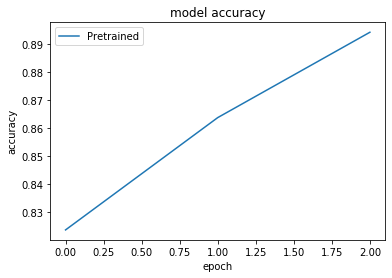

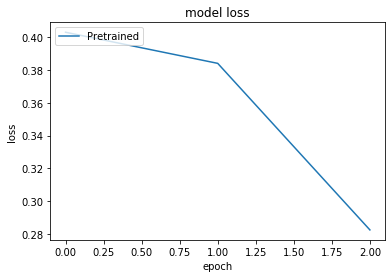

In [45]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Pretrained'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Pretrained'], loc='upper left')
plt.show()

In [54]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [57]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for fea, folder in train_data:
    x_train.append(fea)
    y_train.append(folder)

for fea, folder in test_data:
    x_test.append(fea)
    y_test.append(folder)
    
for fea, folder in val_data:
    x_val.append(fea)
    y_val.append(folder)

In [59]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [60]:
x_train = x_train.reshape(-1, sizeofImg, sizeofImg, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, sizeofImg, sizeofImg, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, sizeofImg, sizeofImg, 1)
y_test = np.array(y_test)

In [65]:
pred = inception_transfer.predict_generator(test_generator)
pred = pred.reshape(1,-1)[0]
pred[:15]

array([0.95491606, 0.53159153, 0.22449973, 0.84997165, 0.5367919 ,
       0.7756432 , 0.51646996, 0.9044061 , 0.2556938 , 0.89145875,
       0.918192  , 0.22758025, 0.11665669, 0.9035237 , 0.9094107 ],
      dtype=float32)

In [68]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(validation_generator.classes, pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

ValueError: Found input variables with inconsistent numbers of samples: [16, 1248]

In [4]:
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet', include_top=False)
result = model.output
result = GlobalAveragePooling2D()(result)
# add a fully-connected layer
result = Dense(512, activation='relu')(result)
# and a fully connected output/classification layer
predictions = Dense(2, activation='sigmoid')(result)
inception_transfer = Model(inputs=model.input, outputs=predictions)
inception_transfer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
import tensorflow as tf
with tf.device("/device:GPU:0"):
    history_pretrained = inception_transfer.fit_generator(
    train_generator,
    epochs=3, shuffle = True, verbose = 1, validation_data = test_generator)

NameError: name 'train_generator' is not defined